<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
<b> This notebook walks us through how to compute a tuning curve using the Allen Brain Observatory data</b>


This notebook has two parts.  The first walks through computing a tuning curves for cells in response to a drifting grating stimulus. This is a classic single-cell analysis, and students can compare the tuning of several cells from the same experiment. The second part looks at correlations between cells that have the same tuning to the drifting grating stimulus from the same experiment. This highlights the fact that our dataset has populations of cells, simultaneously imaged, and allows for examinations of how those cells interact with each other.
This notebook is designed to only reference a single experiment from the Allen Brain Observatory, thus requires only one NWB file to be downloaded. (as downloading NWB files can be time consuming).

### Standard Imports

In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 150
import sys, os
pd.options.display.float_format = '{:,.2f}'.format

### Brain Observatory set up

In [2]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
#if you have put the brain observatory folder somewhere specific (rather than the default), 
#you'll need to point the Cache to the manifest_file. Otherwise, you should be set to go!

boc = BrainObservatoryCache()

## Computing tuning curve for the drifting grating stimulus

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<p>We need:

<li>fluorescence trace for our cell.  We will use the DFF trace
<li>stimulus information for the drifting grating stimulus

</div>

In [3]:
cell_id = 541513979

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
I've created a function here that will return the DF/F trace and the stimulus table if we provide a cell id and a stimulus name. This function leverages functions in the AllenSDK, and there are examples that walk through these steps in other notebooks on the SDK page. I'm happy to explain the steps in greater detail if anyone is interested.  
<p>The key things to know about this.  You provide the function with a cell_specimen_id and a stimulus name.  It returns:
<li>the timestamps for the DF/F trace.  This is a numpy array.
<li>the trace of that cell's DF/F trace for the whole session.  This is also a numpy array.
<li>a table that describes the stimulus conditions and timing.  This is a <b>pandas</b> dataframe.
<p> If you aren't working in AWS, this function can take some time the first time you run it for a given NWB file as it will require that file to be downloaded from the warehouse.
</div>

In [123]:
def get_dff_traces_and_stim_table(cell_specimen_id, stimulus): 
    #identify the session for a given cell id and stimulus
    exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_specimen_id], stimuli=[stimulus])
    #get the session_id for that session
    session_id = exps[0]['id']
    #access the data for that session
    data_set = boc.get_ophys_experiment_data(session_id)
    #get the DFF trace for the cell
    timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_specimen_id])
    dff_trace = dff[0,:]
    #get the stimulus table for the stimulus
    stim_table = data_set.get_stimulus_table(stimulus)
    #return everything
    return (timestamps, dff_trace, stim_table)

In [124]:
timestamps, dff_trace, stim_table = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')
print(timestamps.shape, dff_trace.shape, stim_table.shape)

(115741,) (115741,) (628, 5)


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
First let's plot the DF/F trace of our cell to see what it looks like
</div>

[]

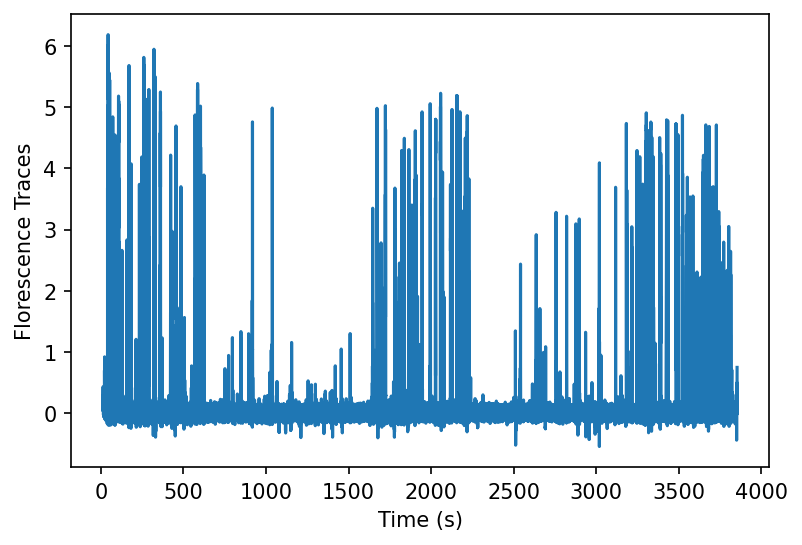

In [6]:
plt.plot(timestamps, dff_trace)
plt.xlabel('Time (s)')
plt.ylabel('Florescence Traces')
plt.plot()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Now let's look at our stimulus table to see what information we have. We just want to see the first few lines, so use the function <b>head</b> to see the top of this DataFrame.
</div>

In [7]:
stim_table.head()

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,NaN,NaN,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158


In [8]:
print(stim_table.temporal_frequency[3])

nan


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The stimulus table has 5 columns.  Start and end indicate the <b>frame number</b> when a given grating condition starts and ends, respectively. The other columns indicate what the grating codition is, including the temporal frequency of the grating (in Hz), the direction (called orientation) of the grating (in degrees), and whether the grating is a blank sweep (eg. a gray screen). 
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Pandas is a very useful python module for data analysis, which has an object called a <b>DataFrame</b> that is a flexible and powerful tool for analyzing large datasets. I highly encourage interested students to explore this analysis module. But for our purposes, we will only use it to access the stimulus information. 
</div>

## Pandas

<div style="border-radius: 3px; padding: 10px;  background: #F0FAFF; ">
<b>Quick pandas tutorial for our purposes today!</b>
<p>
To access data from a DataFrame we must specify the column we are using and specify the row using the <b>index</b>. To specify a column we can use two methods:
<li> stim_table['start']
<li> stim_table.start
<p> Then to specify the row we want we must use the index of that row. 
<li> stim_table['start'][0]
<li> stim_table.start[0]
<p> We can also subselect portions of the DataFrame using the values in the DataFrame. For example, to select only the rows of the table where the orientation is 90 degrees we can use:
<li> stim_table[stim_table.orientation==90]
<p>Try this yourself.  Note the index.  The rows of this subselected DataFrame maintain the indices of the original DataFrame. Now in order to get a specific row, you either need to know it's original index, or use <b>iloc</b>. For example, this will return the first row of the subselected DataFrame regardless of the original index of that row:
<li> stim_table[stim_table.orientation==90].iloc[0]
</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
To look at the cell's response to a given grating presentation, let's plot the DF/F of the cell during the presentation of that grating.  We want to pad the plot with ~ 1 second of the DF/F trace preceding the grating presentation.  1 second = 30 frames.  We'll plot the response to the first grating presentation.
<div>

Text(0.5, 0, 'Frames')

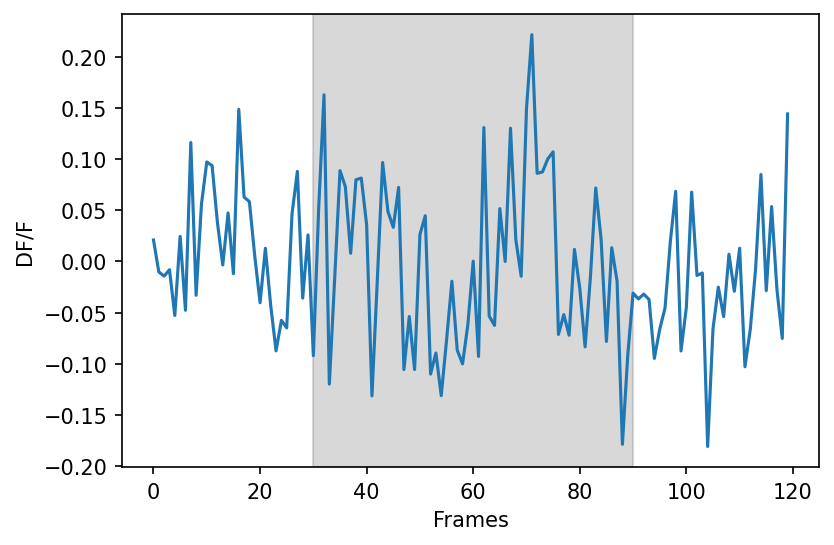

In [9]:
plt.plot(dff_trace[stim_table.start[0]-30:stim_table.end[0]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

We want to quantify this response. We can explore different methods of quantifying this.
* mean DF/F during the grating presentation
* sum of the DF/F during the grating presentation (are these different?)
* maximum DF/F during grating

For now let's use the mean DF/F during the presentation of the grating.

In [10]:
dff_trace[stim_table.start[0]:stim_table.end[0]].mean()

-0.0020014683

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 1:** Repeat this for the next grating stimulus </div>

In [11]:
dff_trace[stim_table.start[1]:stim_table.end[1]].mean()

2.292613

<div style="background: #eab6f0; border-radius: 3px; padding: 10px;">
    <b>Breakout 1</b>
    </div

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Already we can see that some stimulus conditions elicit larger responses than others.  This is what we want to quantify. 

<p><p>To do this, let's calculate the mean DF/F for each grating presentation in this stimulus. To start, let's create a numpy array to hold our calculated responses. We'll have three columns, one for the stimulus orientation, one for temporal frequency, and the last for the response. Then we need to iterate over all stimulus trials, populate the orientation and TF and then calculate the mean response.
    
</div>

In [12]:
cell_response= np.zeros((len(stim_table),3))
for i in range(len(stim_table)):
    cell_response[i,0] = stim_table.orientation[i]
    cell_response[i,1] = stim_table.temporal_frequency[i]
    cell_response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
If we only care about one stimulus parameter, we can quickly compare the response to that parameter, say the direction. Here we will plot each grating response as a function of the grating orientation.
</div>

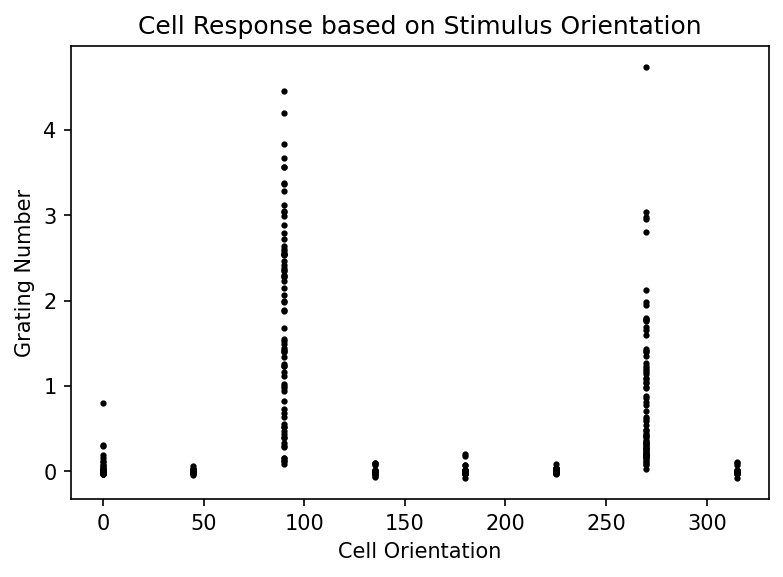

In [13]:
plt.plot(cell_response[:,0], cell_response[:,2], 'ko', ms = 2)
plt.xlabel('Cell Orientation')
plt.ylabel('Grating Number')
plt.title('Cell Response based on Stimulus Orientation')
plt.show()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 2:** Repeat this for the temporal frequency parameter </div>

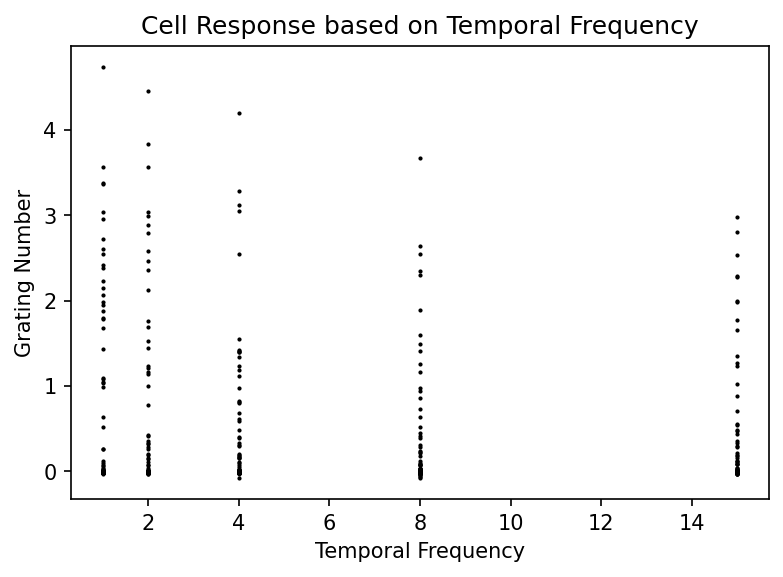

In [14]:
plt.plot( cell_response[:,1], cell_response[:,2], 'ko', ms = 1)
plt.xlabel('Temporal Frequency')
plt.ylabel('Grating Number')
plt.title('Cell Response based on Temporal Frequency')
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
We want to quantify this more explicitly.  So let's average all of the responses to each orientation together. This is the mean DF/F response to an orientation, for all temporal frequencies, for all trials.  For example, for orientation=270: (Hint: use np.where)
</div>

In [15]:
trials = np.where(cell_response[:,0]==270)[0]
cell_response[trials,2].mean()

0.9247032543023427

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 3:** Compute and plot the mean response as a function of orientation
<p> To start, you need to know what all the possible orientation values are. You can either find this from the website, or you can find the <b>unique</b> values that are not NaNs (eg. values that are <b>finite</b>)
</div>

In [16]:
all_ori = np.unique(cell_response[:,0])
orivals = all_ori[np.isfinite(all_ori)]
print(orivals)

[  0.  45.  90. 135. 180. 225. 270. 315.]


In [17]:
cell_orientation_mean = np.zeros((len(orivals), 1))
cell_orientation_std = np.zeros((len(orivals)))

for i in range(len(orivals)):
    trials = np.where(cell_response[:,0]==orivals[i])[0]
    cell_orientation_mean[i] = cell_response[trials,2].mean()
    cell_orientation_std[i] = cell_response[trials,2].std()

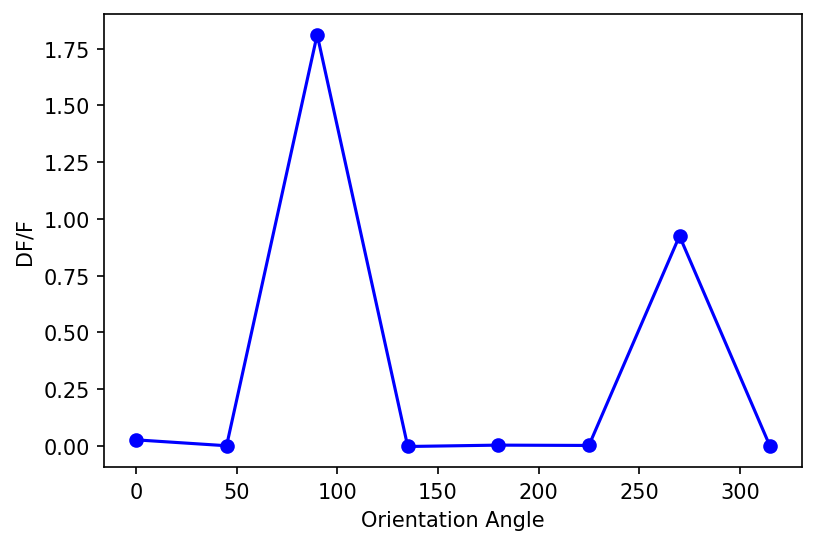

In [18]:
plt.plot(orivals, cell_orientation_mean,'bo-')
plt.xlabel('Orientation Angle')
plt.ylabel('DF/F')
plt.show()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 4:** Compute and plot the mean response as a function of temporal frequency for all orientations. </div>

In [19]:
all_temp = np.unique(cell_response[:,1])
tempvals = all_temp[np.isfinite(all_temp)]

cell_temporal_mean = np.zeros((len(tempvals), 1))
cell_temporal_std = np.zeros((len(tempvals)))

for i in range(len(tempvals)):
    trials = np.where(cell_response[:,1]==tempvals[i])[0]
    cell_temporal_mean[i] = cell_response[trials,2].mean()
    cell_temporal_std[i] = cell_response[trials,2].std()
    
print(tempvals)

[ 1.  2.  4.  8. 15.]


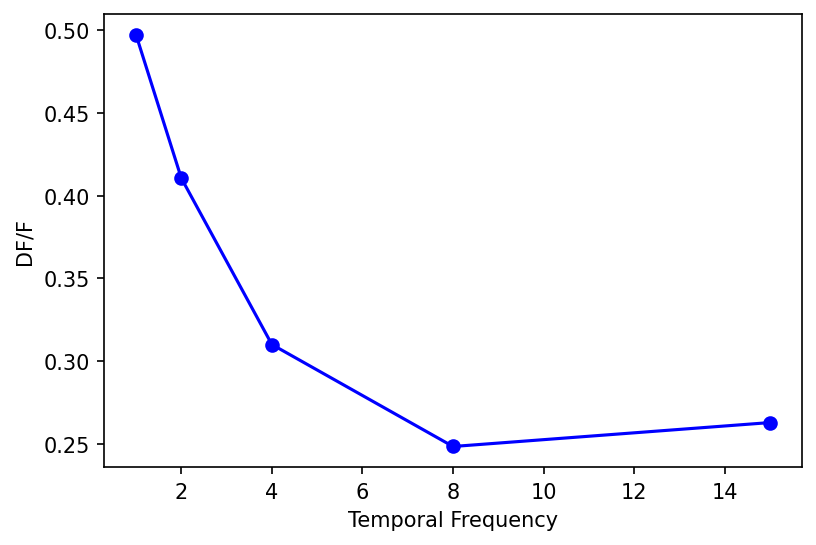

In [20]:
plt.plot(tempvals, cell_temporal_mean, 'bo-')
plt.xlabel('Temporal Frequency')
plt.ylabel('DF/F')
plt.show()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 5:** Add errorbars to the above tuning curves. They can be standard deviation or standard error or the mean.  (Hint: plt.errorbar might be a useful function).
</div>

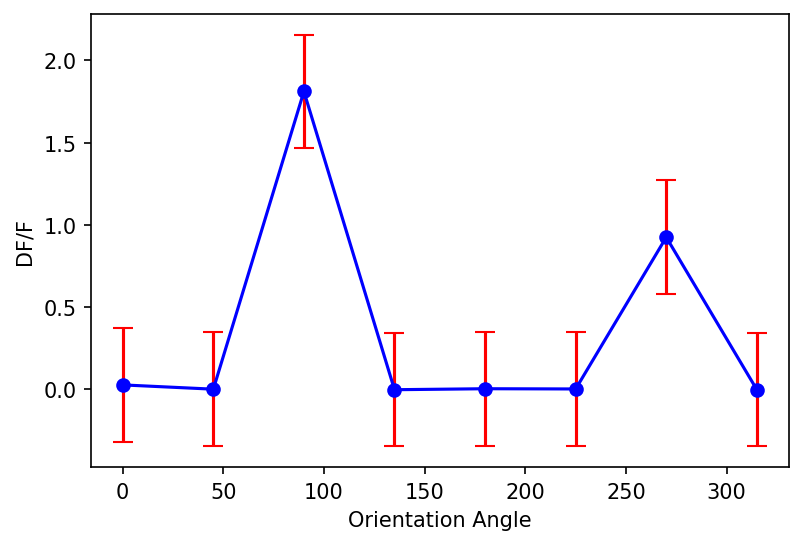

In [21]:
plt.errorbar(orivals, cell_orientation_mean, cell_orientation_mean.mean(), fmt = 'bo-', capsize = 5, ecolor = 'r')
plt.xlabel('Orientation Angle')
plt.ylabel('DF/F')
plt.show()

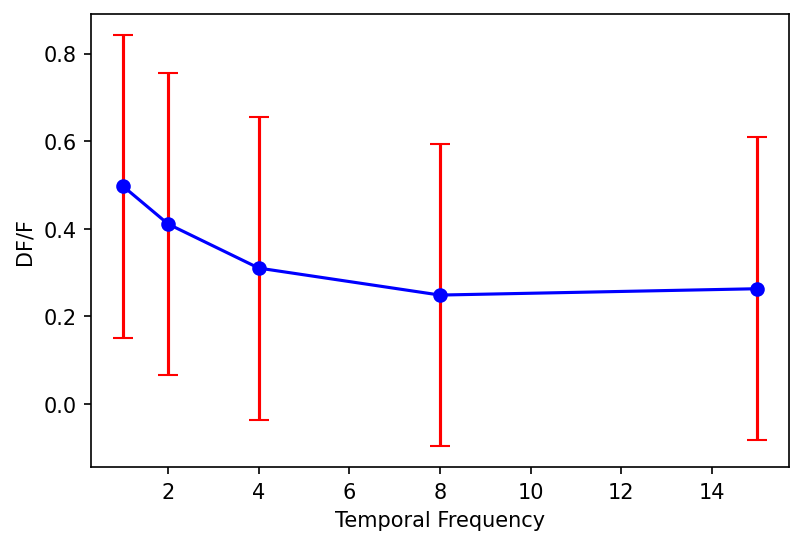

In [22]:
plt.errorbar(tempvals, cell_temporal_mean, cell_temporal_mean.mean(), fmt = 'bo-', capsize = 5, ecolor = 'r')
plt.xlabel('Temporal Frequency')
plt.ylabel('DF/F')
plt.show()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
**Exercise 6:** Add a black line showing the mean response to the blank sweep (Hint 1: orientation and temporal frequency are NaN for the blank sweep condition.  Hint 2: plt.axhline might be a useful function).  </div>

In [23]:
stim_table_black = stim_table[stim_table.blank_sweep == 1]
blackvals = np.array([stim_table_black.index]).reshape(-1)

cell_orientation_black_mean = np.zeros((len(blackvals), 1))
cell_orientation_black_std = np.zeros((len(blackvals)))

for i in range(len(blackvals)):
    cell_orientation_black_mean[i] = cell_response[blackvals,2].mean()

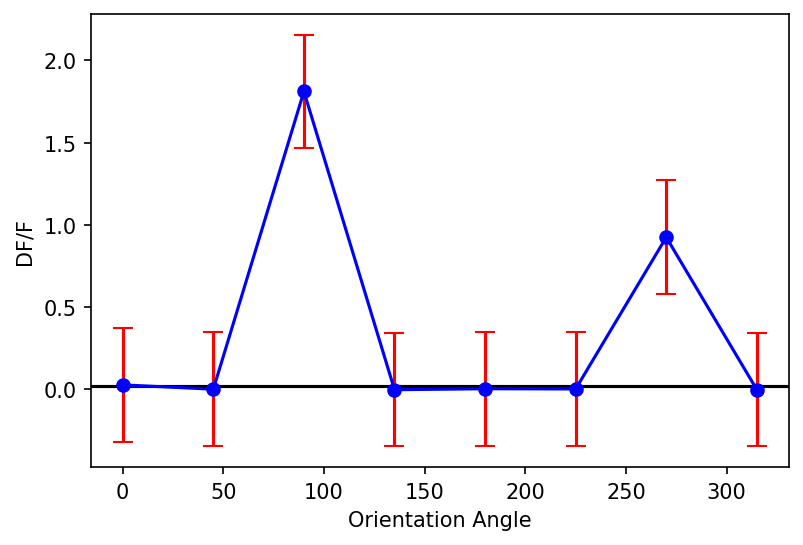

In [24]:
plt.errorbar(orivals, cell_orientation_mean, cell_orientation_mean.mean(), fmt = 'bo-', capsize = 5, ecolor = 'r')
plt.axhline(y = cell_orientation_black_mean.mean(), color = 'k')
plt.xlabel('Orientation Angle')
plt.ylabel('DF/F')
plt.show()

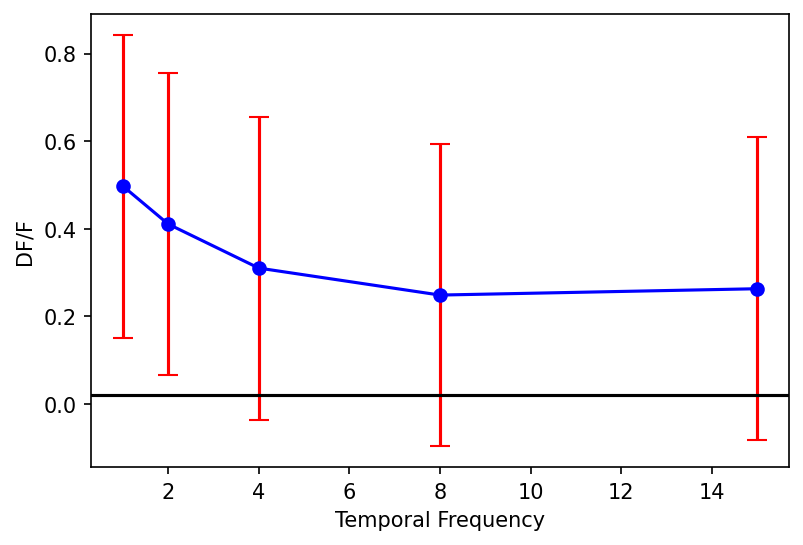

In [25]:
plt.errorbar(tempvals, cell_temporal_mean, cell_temporal_mean.mean(), fmt = 'bo-', capsize = 5, ecolor = 'r')
plt.axhline(y = cell_orientation_black_mean.mean(), color = 'k')
plt.xlabel('Temporal Frequency')
plt.ylabel('DF/F')
plt.show()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 7:** Compute and plot the direction tuning curve separately for each of the 5 temporal frequencies. </div>

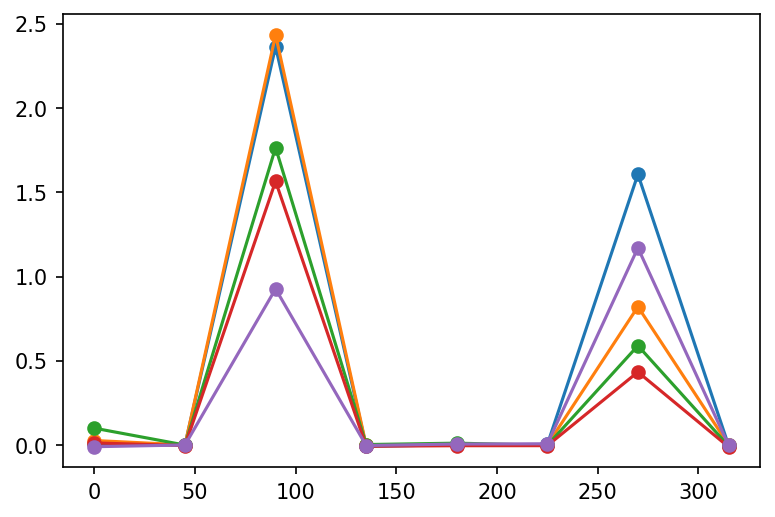

In [26]:
cell_tuning = np.zeros((len(orivals), len(tempvals)))

for jj in range(len(tempvals)):
    for i in range(len(orivals)):
        trials = np.where(np.logical_and((cell_response[:,1] == tempvals[jj]), (cell_response[:,0] == orivals[i])))[0]
        cell_tuning[i,jj] = cell_response[trials,2].mean()

for kk in range(len(tempvals)):
    plt.plot(orivals, cell_tuning[:,kk], 'o-')
plt.show()

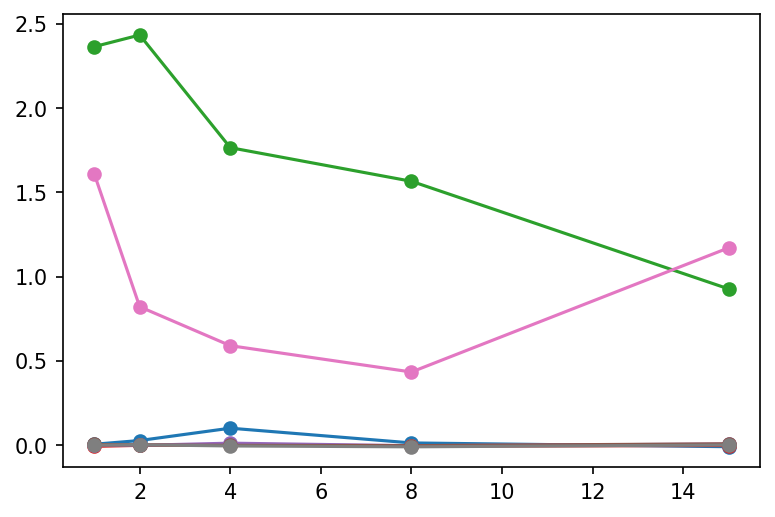

In [27]:
for kk in range(len(orivals)):
    plt.plot(tempvals, cell_tuning[kk,:], 'o-')
plt.show()

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 8:** Are there other ways to visualize these tuning responses? </div>

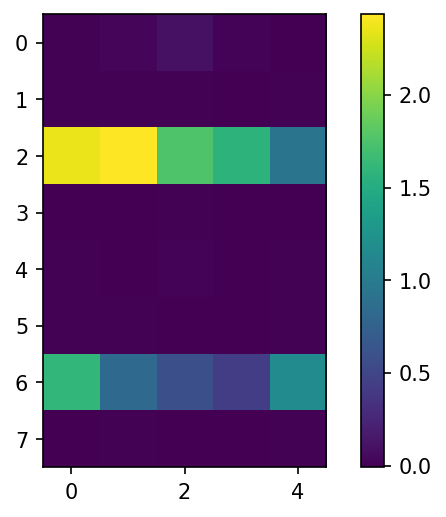

In [28]:
plt.imshow(cell_tuning)
plt.colorbar()
plt.show()

<div style="background: #eab6f0; border-radius: 3px; padding: 10px;">
    <b>Breakout 2</b>
    </div

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
We've looked at the tuning curve for one cell. There are a lot of other cells in this experiment. Now we're going to see what some of the other cells in this experiment look like, and start the explore how the different cells might interact.

</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 9:** Compute the tuning curves for cell_ids 541512490, 541512611, 541512645, 541512079, 541511403, 541511670, 541511373, 541513771, 541511385, 541512607. (Hint: it might be helpful to write a function) In what ways do these tuning curves differ? In what ways are they the same? What are interesting parameters of a cell's response to this stimulus?  </div>

In [29]:
def compute_ori_tf_tuning(cell_id):
    timestamps, dff_trace, stimtable = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')
    
    cellresponse = np.zeros((len(stimtable),3))
    
    for i in range(len(stim_table)):
        cellresponse[i,0] = stimtable.orientation[i]
        cellresponse[i,1] = stimtable.temporal_frequency[i]
        cellresponse[i,2] = dff_trace[stimtable.start[i]:stimtable.end[i]].mean()
    
    all_ori = np.unique(cellresponse[:,0])
    all_temp = np.unique(cellresponse[:,1])
    orivals = all_ori[np.isfinite(all_ori)]
    tempvals = all_temp[np.isfinite(all_temp)]
    
    celltuning = np.zeros((len(orivals), len(tempvals)))
    
    for jj in range(len(tempvals)):
        for i in range(len(orivals)):
            trials = np.where(np.logical_and((cellresponse[:,1] == tempvals[jj]), (cellresponse[:,0] == orivals[i])))[0]
            celltuning[i,jj] = cellresponse[trials,2].mean()
    
    plt.imshow(celltuning)
    plt.title('{}'.format(cell_id))
    plt.colorbar()
    
    return plt.show()

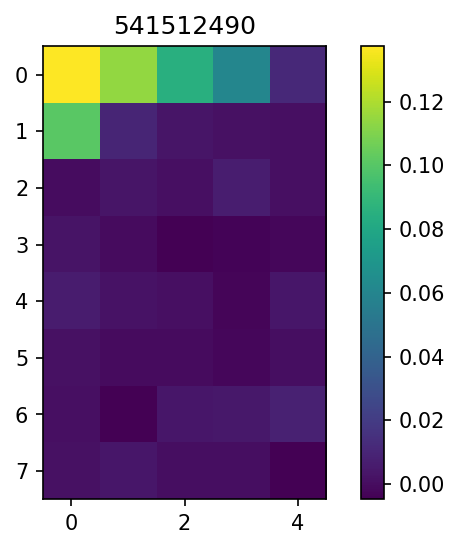

In [30]:
compute_ori_tf_tuning(541512490)

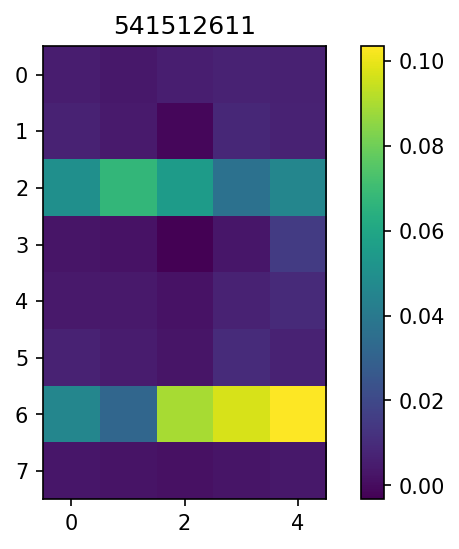

In [31]:
compute_ori_tf_tuning(541512611)

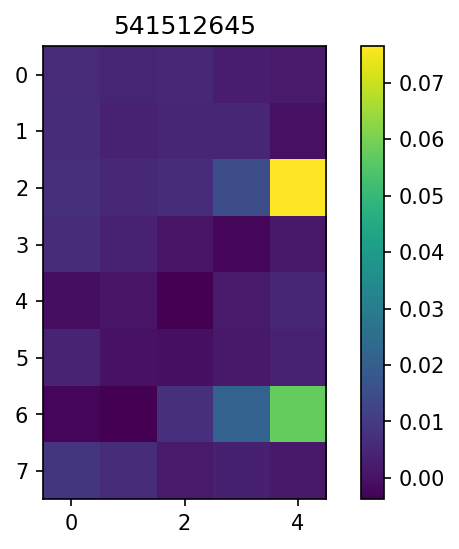

In [32]:
compute_ori_tf_tuning(541512645)

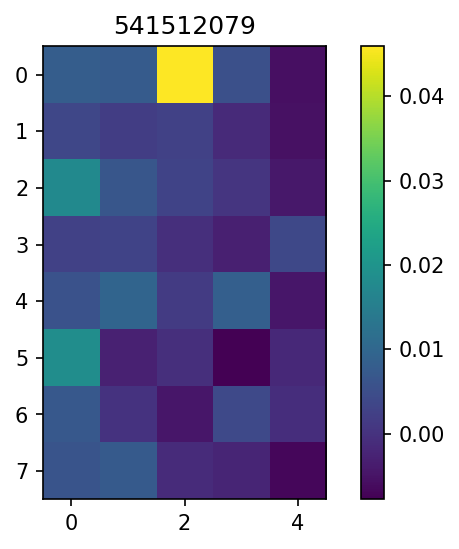

In [33]:
compute_ori_tf_tuning(541512079)

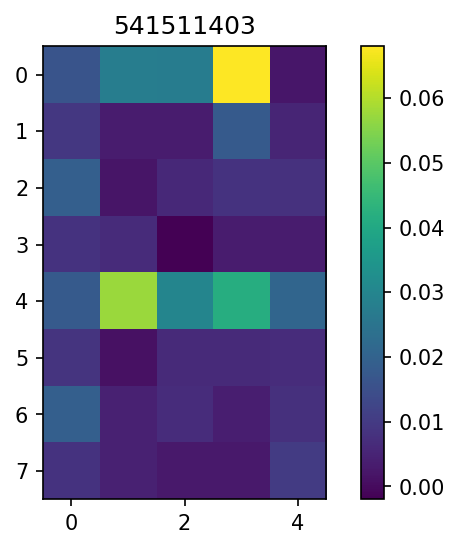

In [34]:
compute_ori_tf_tuning(541511403)

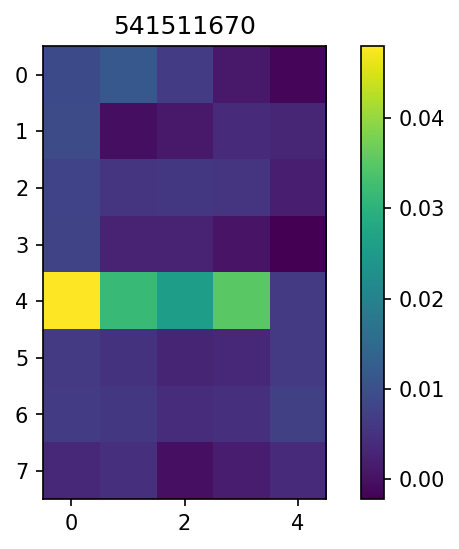

In [35]:
compute_ori_tf_tuning(541511670)

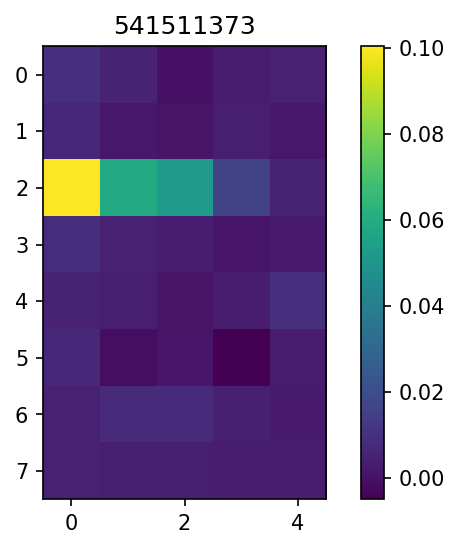

In [36]:
compute_ori_tf_tuning(541511373)

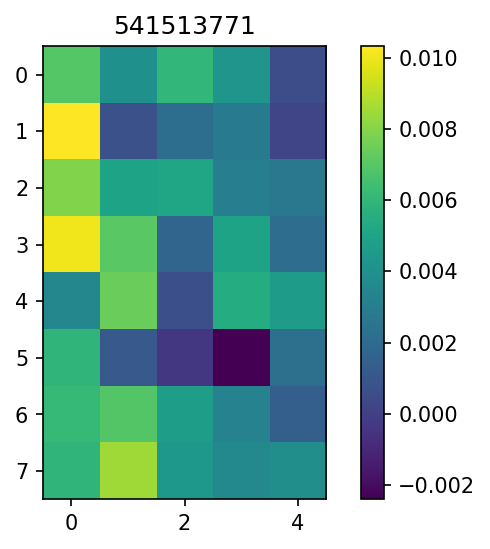

In [37]:
compute_ori_tf_tuning(541513771)

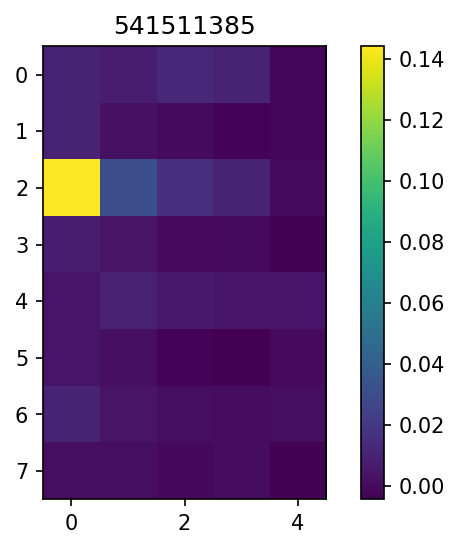

In [38]:
compute_ori_tf_tuning(541511385)

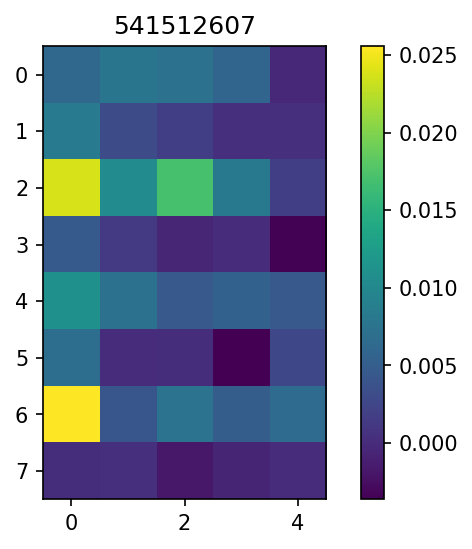

In [39]:
compute_ori_tf_tuning(541512607)

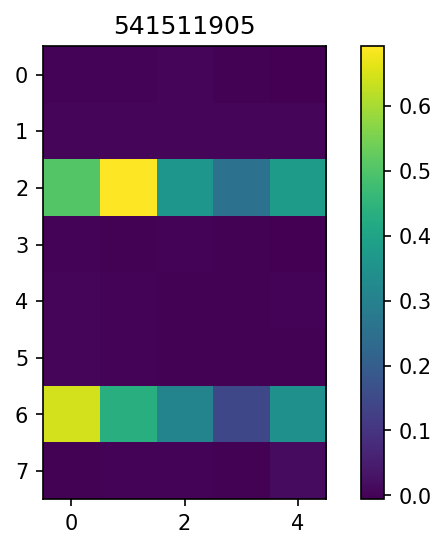

In [40]:
compute_ori_tf_tuning(541511905)

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Some of these cells show the same tuning for orientation and temporal frequency. Now let's look at these more closely to see how they are <i>correlated</i>.

<p>If you've overwritten the dff_trace, go back and get the trace for our original cell: cell_id = 541513979
<p>Also get the trace for cell 541511905, let's call this trace "dff_trace_2"
</div style>

In [41]:
cell_id = 541513979
timestamps, dff_trace_1, stim_table1 = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')

In [42]:
new_cell_id = 541511905
timestamps, dff_trace_2, stim_table2 = get_dff_traces_and_stim_table(new_cell_id, 'drifting_gratings')

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
These two cells have some similarities in their tuning preferences, but how similar are their responses?
</div>

<div style="border-radius: 3px; padding: 10px;  background: #F0FAFF; ">
<b>Correlations</b>
<p>
We can compute a correlation coefficient to measure the relationship between two variables - in this case the responses of two different cells. When cell A has a large response, does cell B also have a strong response? 
<p> We will use Pearson correlation coefficient, which is defined as:
<img src="correlation_coefficient_formula.svg">
<p> where x and y are the two variables in question. We will use a function from scipy.stats to compute this for us.
<p> If the two variables are positively correlated, a large response from cell A will be matched with a large response in cell B. If they are weakly correlated, the response size of cell A will have not relationship with the response size of cell B. And if they are negatively correlated, cell B will have small responses when cell A has large responses.
<img src="pearson-2-small.png">
</div>

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 10:** Compute the correlation between these two cells' traces. We're going to use st.pearsonr from scipy.stats
</div>

In [43]:
import scipy.stats as st

In [44]:
r,p = st.pearsonr(dff_trace_1, dff_trace_2)
print(r)

0.5628775961334614


<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 11:** Calculate the response of the second cell to all the stimulus trials and compute the correlation between these two cells' responses.
</div>

In [45]:
cellresponse1 = np.zeros((len(stim_table1),3))
    
for i in range(len(stim_table)):
    cellresponse1[i,0] = stim_table1.orientation[i]
    cellresponse1[i,1] = stim_table1.temporal_frequency[i]
    cellresponse1[i,2] = dff_trace_1[stim_table1.start[i]:stim_table1.end[i]].mean()

In [46]:
cellresponse2 = np.zeros((len(stim_table2),3))
    
for i in range(len(stim_table2)):
    cellresponse2[i,0] = stim_table2.orientation[i]
    cellresponse2[i,1] = stim_table2.temporal_frequency[i]
    cellresponse2[i,2] = dff_trace_2[stim_table2.start[i]:stim_table2.end[i]].mean()

In [47]:
r,p = st.pearsonr(cellresponse1[:,2],cellresponse2[:,2])
print(r)

0.7640585294224913


<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 12:** Calculate the orientation tuning curve for the second cell and compute the correlation between these two cells' tuning. Hint: you will need to <b>flatten</b> the tuning array.
</div>

In [48]:
all_ori = np.unique(cellresponse1[:,0])
orivals = all_ori[np.isfinite(all_ori)]

cell_orientation1_mean = np.zeros((len(orivals), 1))

for i in range(len(orivals)):
    trials = np.where(cellresponse1[:,0]==orivals[i])[0]
    cell_orientation1_mean[i] = cellresponse1[trials,2].mean()
    
all_ori = np.unique(cellresponse2[:,0])
orivals = all_ori[np.isfinite(all_ori)]

cell_orientation2_mean = np.zeros((len(orivals), 1))

for i in range(len(orivals)):
    trials = np.where(cellresponse2[:,0]==orivals[i])[0]
    cell_orientation2_mean[i] = cellresponse2[trials,2].mean()

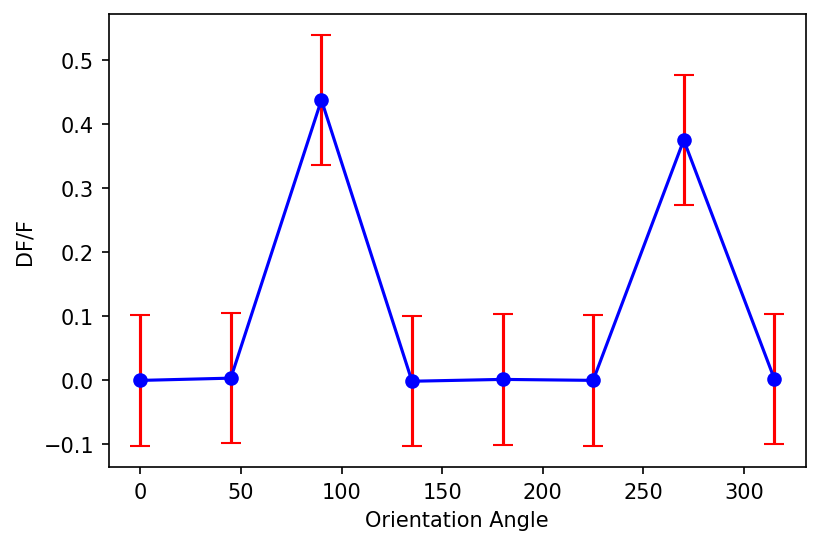

In [49]:
plt.errorbar(orivals, cell_orientation2_mean, cell_orientation2_mean.mean(), fmt = 'bo-', capsize = 5, ecolor = 'r')
plt.xlabel('Orientation Angle')
plt.ylabel('DF/F')
plt.show()

In [50]:
r, p = st.pearsonr(cell_orientation1_mean.flatten(),cell_orientation2_mean.flatten())
print(r)

0.9635345977078275


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
We've looked at three different correlations. Discuss why these correlations are different and what it might tell you about these two cells.
    
</div style>

They respond to the same stimulus orientation.

<div style="background: #FFF0F0; border-radius: 3px; padding: 10px;">
<p>**Exercise 13:** Repeat these three correlation computations for cells 541511373 and 541511385. Notice anything similar or different from the previous pair?
</div>

In [51]:
cell_id = 541511373
timestamps, dff_trace_3, stim_table3 = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')
cell_id = 541511385
timestamps, dff_trace_4, stim_table4 = get_dff_traces_and_stim_table(cell_id, 'drifting_gratings')


In [52]:
r,p = st.pearsonr(dff_trace_3, dff_trace_4)
print(r)

0.05903301704433086


In [53]:
cellresponse3 = np.zeros((len(stim_table3),3))
    
for i in range(len(stim_table)):
    cellresponse3[i,0] = stim_table3.orientation[i]
    cellresponse3[i,1] = stim_table3.temporal_frequency[i]
    cellresponse3[i,2] = dff_trace_3[stim_table3.start[i]:stim_table3.end[i]].mean()
    
cellresponse4 = np.zeros((len(stim_table4),3))
    
for i in range(len(stim_table2)):
    cellresponse4[i,0] = stim_table4.orientation[i]
    cellresponse4[i,1] = stim_table4.temporal_frequency[i]
    cellresponse4[i,2] = dff_trace_4[stim_table4.start[i]:stim_table4.end[i]].mean()

In [54]:
r,p = st.pearsonr(cellresponse3[:,2],cellresponse4[:,2])
print(r)

0.44830092124999266


In [55]:
all_ori = np.unique(cellresponse3[:,0])
orivals = all_ori[np.isfinite(all_ori)]

cell_orientation3_mean = np.zeros((len(orivals), 1))

for i in range(len(orivals)):
    trials = np.where(cellresponse3[:,0]==orivals[i])[0]
    cell_orientation3_mean[i] = cellresponse3[trials,2].mean()
    
all_ori = np.unique(cellresponse4[:,0])
orivals = all_ori[np.isfinite(all_ori)]

cell_orientation4_mean = np.zeros((len(orivals), 1))

for i in range(len(orivals)):
    trials = np.where(cellresponse4[:,0]==orivals[i])[0]
    cell_orientation4_mean[i] = cellresponse4[trials,2].mean()

In [56]:
r, p = st.pearsonr(cell_orientation3_mean.flatten(),cell_orientation4_mean.flatten())
print(r)

0.9864600493498009


<div style="background: #eab6f0; border-radius: 3px; padding: 10px;">
    <b>Breakout 3</b>
    </div

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

Everything so far has looked at the responses of these cells to 'driftings_gratings'. Now let's look at their responses to 'natural_movie_three' and see how it compares to their grating responses.

</div>

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Use the function from the start of this notebook to get the timestamps, dff trace, and stimulus table for our original cell (cell_id = 541513979) for 'natural_movie_three'. Look at the stimulus table. How is it different from the stimulus table for drifting gratings?
</div style>

In [57]:
cell_id = 541513979
timestamps, dff_trace_nm1, stim_table_nm1 = get_dff_traces_and_stim_table(cell_id, 'natural_movie_three')

cell_id = 541511905
timestamps, dff_trace_nm2, stim_table_nm2 = get_dff_traces_and_stim_table(cell_id, 'natural_movie_three')

cell_id = 541511373
timestamps, dff_trace_nm3, stim_table_nm3 = get_dff_traces_and_stim_table(cell_id, 'natural_movie_three')

cell_id = 541511385
timestamps, dff_trace_nm4, stim_table_nm4 = get_dff_traces_and_stim_table(cell_id, 'natural_movie_three')

In [58]:
stim_table_nm1.head()

,frame,start,end,repeat
0,0,19746,19747,0
1,1,19747,19748,0
2,2,19748,19749,0
3,3,19749,19750,0
4,4,19750,19751,0


This table only displays the start and end times of each respect frame of the movie and how many times it has repeated.

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The movie is repeated 10 times. Each repeat begins when frame 0 is presented. Find the start times for each movie repeat.
</div style>

In [59]:
start_times = stim_table_nm1[stim_table_nm1.frame==0].start.values

In [60]:
start_times

array([19746, 23367, 26987, 30608, 34229, 75869, 79490, 83110, 86731,
       90353])

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Now we're going to average each cell's response to the movie. Start from the start time you just found above. The movie is 3600 frames long (you can check that by finding how many unique frames there are in the stimulus table). So make an array that is size (10,3600) and put the response of the cell for each of the 10 trials in the array. Then average across those 10 trials and plot the result. Do this for both of the two cells we looked at in exercises 10-12.
</div style>

In [61]:
movie_response1 = np.zeros((10,3600))
movie_response2 = np.zeros((10,3600))

for jj in range(len(start_times)):
    movie_response1[jj,:] = dff_trace_nm1[start_times[jj]:(start_times[jj]+3600)]
    movie_response2[jj,:] = dff_trace_nm2[start_times[jj]:(start_times[jj]+3600)]

In [62]:
movie_response1_mean = np.mean(movie_response1, axis = 0)
movie_response2_mean = np.mean(movie_response2, axis = 0)

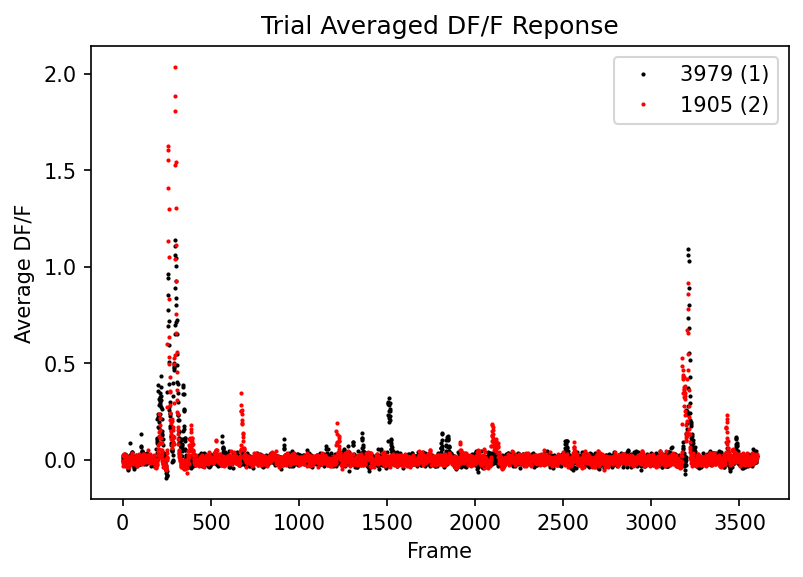

In [63]:
plt.plot(movie_response1_mean, 'ko', ms = 1, label = '3979 (1)')
plt.plot(movie_response2_mean, 'ro', ms = 1, label = '1905 (2)')
plt.xlabel('Frame')
plt.ylabel('Average DF/F')
plt.title('Trial Averaged DF/F Reponse')
plt.legend()
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
The two cells we're looking at have similar tuning curves for their drifting grating responses (see above). Do you expect they have similar responses for the natural movie? Why or why not? Compute the correlation between the averaged movie responses of these two cells. How does it compare to the correlation of their tuning to the drifting gratings? Why might they be similar? Why might they be different?
</div style>

I expect both cells to have a similar response to the natural movie as they had a medium-to-strong correlation in their dritfting grating responses. Since both stimuli had similar qualitative results to their tuning curves, it should follow that they respond similarly to the same movies over and over again. The natural movie the cells watch are comprised of different stimuli smooshed together. It then follows that if a stimulus pattern that is similar to one of the response causing drifting gratings is presented in the movie, then the cell will respond. Now, if they both have similar drifting grating responses or they are correlated, then it follows that the sum of these various response causing patterns, the movie, will also produce a correlated response.

In [64]:
r,p = st.pearsonr(np.mean(movie_response1, axis = 0), np.mean(movie_response2,axis = 0))
print('Correlation Across Frames:',r)

Correlation Across Frames: 0.7509293926390077


The correlation between the two cells is high, as expected. The correlation was nearly identitcal, the gratings 0.76 and the movie 0.75, indicating that their correlation between gratings translated almost exactly to the correlation in the natural viewing. This indicates that the cells will respond appropriately to excitatory stimuli irregardless of the form or uniformity of the stimulus, as in the movie. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
Do the same comparison for the second pair of cells that you looked at for the drifting gratings, cells 541511373 and 541511385.
</div style>

In [65]:
movie_response3 = np.zeros((10,3600))
movie_response4 = np.zeros((10,3600))

for jj in range(len(start_times)):
    movie_response3[jj,:] = dff_trace_nm3[start_times[jj]:(start_times[jj]+3600)]
    movie_response4[jj,:] = dff_trace_nm4[start_times[jj]:(start_times[jj]+3600)]
    
movie_response3_mean = np.mean(movie_response3, axis = 0)
movie_response4_mean = np.mean(movie_response4, axis = 0)

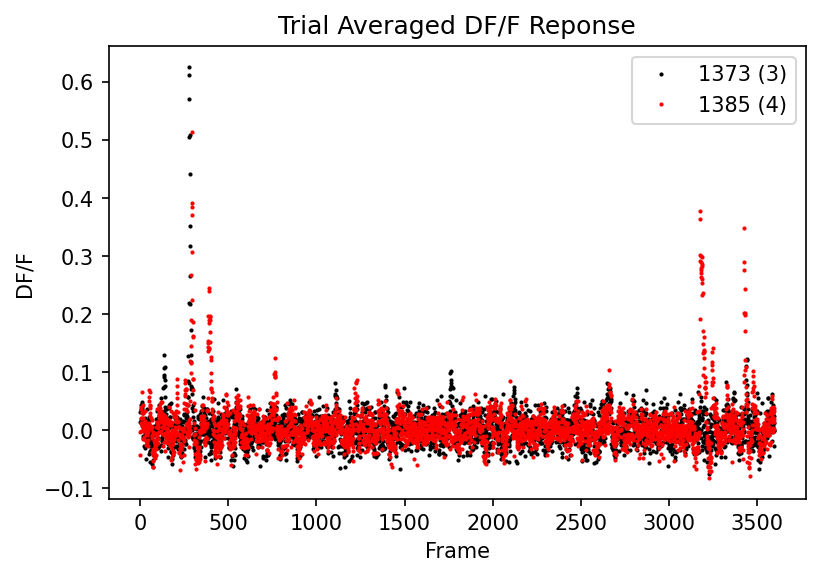

In [66]:
plt.plot(movie_response3_mean, 'ko', ms = 1, label = '1373 (3)')
plt.plot(movie_response4_mean, 'ro',ms = 1, label = '1385 (4)')
plt.xlabel('Frame')
plt.ylabel('DF/F')
plt.title('Trial Averaged DF/F Reponse')
plt.legend()
plt.show()

In [67]:
r,p = st.pearsonr(np.mean(movie_response3, axis = 0), np.mean(movie_response4,axis = 0))
print('Correlation Across Frames:',r)

Correlation Across Frames: 0.12840115710291725


Judging by the correlation from the drifting gratings, I expect the two cells to have a low-to-medium correlation as some components of their temporal frequency and orientation tuning values line up, but a few others don't. This'll mean that, in some cases, one cell will respond to stimuli while the other won't respond.

The correlation of 0.13 is a little higher than the 0.06 of the DF/F correlation but is considerably lower than the 0.44 correlation for the mean response. This indicates that the there might've been a stimulus which one cell responds strongly to, presented at around from 3250 and 3500, that cell 1385 responded to while cell 1373 didn't. The behavior as a whole for both cells, unlike the previous two cells, however, is extremely erratic indicating there is a lot of stimulus which the both cells respond at a low level to.

<div style="background: #fcdc83; border-radius: 3px; padding: 10px;">
For an extra challenge, what is the relationship between the correlation of grating responses to the correlation of movie responses across the whole population? To do this, you'll want to get the traces for all of the cells in the experiment. Look at our function at the beginning called get_dff_traces_and_stim_table(). If you use some of the code in there, and change the get_dff_traces line to:
    
> timestamps, dff = data_set.get_dff_traces()

you will get an array of the DFF traces of all of the cells. From there you can calculate tuning for all the cells and calculate the pairwise correlations. What do you expect the result to be?
    
</div style>

In [171]:
exps = boc.get_ophys_experiments(stimuli=['natural_movie_three'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)
nmtimestamps, nmdff = data_set.get_dff_traces()
nmstim_table = data_set.get_stimulus_table('natural_movie_three')

exps = boc.get_ophys_experiments(stimuli=['drifting_gratings'])
session_id = exps[0]['id']
data_set = boc.get_ophys_experiment_data(session_id)
dgtimestamps, dgdff = data_set.get_dff_traces()
dgstim_table = data_set.get_stimulus_table('drifting_gratings')

In [176]:
start_times = nmstim_table[nmstim_table.frame==0].start.values
movie_response = np.zeros((10, 3600, 26))
dgcell_response= np.zeros((len(dgstim_table), 3, 26))

for kk in range(26):
    for jj in range(len(start_times)):
        movie_response[jj,:,kk] = nmdff[kk,start_times[jj]:(start_times[jj]+3600)]
    
movie_response_mean = np.mean(movie_response, axis = 0)

for kk in range(26):
    for i in range(len(stim_table)):
        dgcell_response[i,0,kk] = dgstim_table.orientation[i]
        dgcell_response[i,1,kk] = dgstim_table.temporal_frequency[i]
        dgcell_response[i,2,kk] = dgdff[kk,stim_table.start[i]:stim_table.end[i]].mean()

In [205]:
dgr = np.zeros((26,26))
nmr = np.zeros((26,26))
rdist = np.zeros((26,26))

for ii in range(26):
    for jj in range(26):
        rdg, p = st.pearsonr(dgcell_response[:,2,ii], dgcell_response[:,2,jj])
        dgr[ii,jj] = rdg
        rnm, p = st.pearsonr(movie_response_mean[:,ii], movie_response_mean[:,jj])
        nmr[ii,jj] = rnm
        
rdist = (dgr - nmr)**2

dgrpd = pd.DataFrame(dgr)
nmrpd = pd.DataFrame(nmr)

In [206]:
avgrdist = np.sum(rdist)/(26**2)/2
print(avgrdist)

#np.round(dgrpd, decimals = 3)
#np.round(nmrpd, decimals = 3)

0.007428336214093616


By calculating the correlation between each cell in the population to each other for both their drifting grating and natural movie responses, I can then find the average distance between each of their different correlations. For example, if Cell A and Cell B have a strong correlation for their drifting grating DF/F responses and an equally strong correlation between their natural movie DF/F responses, then their distance should be near zero. Doing this for all combinations of for the population, $\frac{26^2}{2}$ combinations (comparing Cell A to Cell B is the same comparing as Cell B to Cell A). If this average correlation distance is closer to zero, then the drifting grating and natural movie response correlations over the whole population are very close. If they are very close then it follows that if two the drifting grating responses of different cells are highly correlated, then their natural movie response correlations will also be high. 

Looking at the average correlation distance, $0.007$, implies that the drifting grating and natural movie correlations are almost identical. If the correlation between two cell gratings is known, then the correlation between the cells reacting to a piece of medium can be known if one of the reactions is known.